In [118]:
%load_ext autoreload
%autoreload 2

import kaolin
import numpy as np
mesh_name = "sphere"
kmesh = kaolin.io.obj.import_mesh(f"meshes/{mesh_name}_remesh_lvl1.obj")
vertices = kmesh.vertices.cpu().numpy()
faces = kmesh.faces.cpu().numpy()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
W = 256
volume = np.load(f"Trained/2023-12-01_t1_3D_0333/offline_ondemand_volume_{W}_{W}_{W}.npy")
# volume = np.load("Trained/2023-12-01_brown016_exemplar_3D_0130/offline_ondemand_volume_1024_1024_1024.npy")
volume = volume.transpose(1, 2, 3, 0)

In [79]:
def trilinear(xyz, data):
    '''
    xyz: array with coordinates inside data
    data: 3d volume
    returns: interpolated data values at coordinates
    '''
    ijk = xyz.astype(np.int32)
    i, j, k = ijk[:,0], ijk[:,1], ijk[:,2]
    V000 = data[ i   , j   ,  k   ].astype(np.int32)
    V100 = data[(i+1), j   ,  k   ].astype(np.int32)
    V010 = data[ i   ,(j+1),  k   ].astype(np.int32)
    V001 = data[ i   , j   , (k+1)].astype(np.int32)
    V101 = data[(i+1), j   , (k+1)].astype(np.int32)
    V011 = data[ i   ,(j+1), (k+1)].astype(np.int32)
    V110 = data[(i+1),(j+1),  k   ].astype(np.int32)
    V111 = data[(i+1),(j+1), (k+1)].astype(np.int32)
    xyz = xyz - ijk
    x, y, z = xyz[:,0:1], xyz[:,1:2], xyz[:,2:3]
    Vxyz = (V000 * (1 - x)*(1 - y)*(1 - z)
            + V100 * x * (1 - y) * (1 - z) +
            + V010 * (1 - x) * y * (1 - z) +
            + V001 * (1 - x) * (1 - y) * z +
            + V101 * x * (1 - y) * z +
            + V011 * (1 - x) * y * z +
            + V110 * x * y * (1 - z) +
            + V111 * x * y * z)
    return Vxyz

# Render by face color (Interpolation)

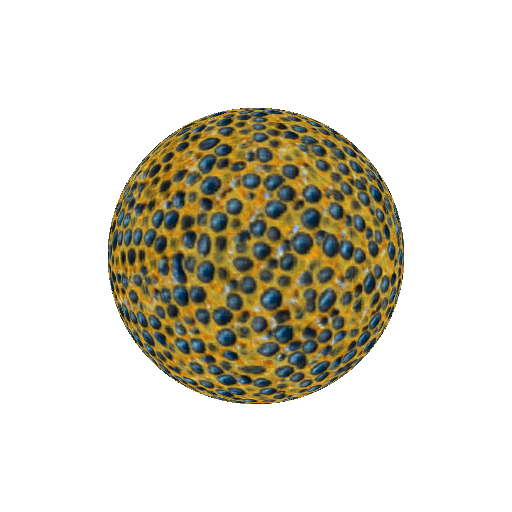

In [139]:
from render import Renderer
import torch
from PIL import Image

device = torch.device("cuda:0")

from tqdm import tqdm


height, width = 512, 512
num_views = 1
renderer = Renderer(device=device, dim=(height, width))

with torch.no_grad():
    # colors = torch.rand_like(kmesh.vertices).to(device)
    V = kmesh.vertices[None, :].to(device) / 2.1
    # C = torch.rand_like(V).to(device)
    C = torch.tensor(colors, device=device, dtype=torch.float32)[None, :]
    F = kmesh.faces.to(device)
    coords, masks = renderer.get_projected_coordinates(V, F, num_views=num_views)
    coords = coords.cpu().numpy()
    masks = masks.cpu().numpy()[..., 0]
    
    xyz = coords + 1.0 / 2.1
    xyz = xyz.reshape(-1, 3)
    H, W, D, _ = volume.shape
    colors = trilinear(xyz * H , volume) / 255.0
    colors = colors.reshape(num_views, height, width, 3)
    colors[masks == 0.0] = 1.0
    img = colors[0]
    # img = np.vstack([np.hstack(colors[i::2]) for i in range(2)])
    
    
    
img = Image.fromarray((img * 255.0).astype(np.uint8))
img

# Render by vertex color

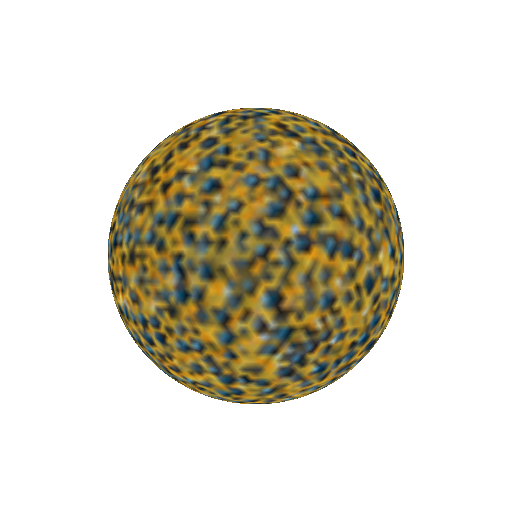

In [144]:
from render import Renderer
import torch
from PIL import Image

device = torch.device("cuda:0")

from tqdm import tqdm

height, width = 512, 512
num_views = 1

renderer = Renderer(device=device, dim=(height, width))

with torch.no_grad():
    xyz = (vertices + 1.0) / 2.1
    H, W, D, _ = volume.shape
    colors = trilinear(xyz * H , volume) / 255.0
    
    V = kmesh.vertices[None, :].to(device) / 2.1
    F = kmesh.faces.to(device)    
    C = torch.tensor(colors, device=device, dtype=torch.float32)[None, :]
    O = renderer.render_fixed_views(V, F, C, lighting=False,
                                    num_views=num_views, 
                                    background=torch.tensor([1.0, 1.0, 1.0], device=device))
    O = O.detach().cpu().numpy().transpose(0, 2, 3, 1)
    img = O[0]
    # img = np.vstack([np.hstack(O[i::2]) for i in range(2)])
    
img = Image.fromarray((img * 255.0).astype(np.uint8))
img